In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===DATA===
PATH = '/content/drive/MyDrive/gh/kaggle/dacon'
train = pd.read_csv(PATH + '/bicycle/dataset/train.csv')
test = pd.read_csv(PATH + '/bicycle/dataset/test.csv')
sample_submission = pd.read_csv(PATH + '/bicycle/dataset/sample_submission.csv')
# train.head(20)

In [ ]:
# ===UTILS===

# 1. seperate datetime
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point)-2017)
        month.append(int(month_point)-3)
        day.append(int(day_point))
    return year, month, day


# 2. weekday
def create_weekday(dataframe):
    week_day = pd.to_datetime(dataframe['date_time']).dt.day_name()
    le = LabelEncoder()
    le.fit(week_day)
    return le.transform(week_day)

# 3. weekend
def holiday_cat(week_day):
  if week_day in ['Sunday'] :
    return 1
  else :
    return 0


def create_weekend(dataframe):
    week_day = pd.to_datetime(dataframe['date_time']).dt.day_name()
    dataframe['week_day'] = week_day
    return dataframe.apply(lambda x : holiday_cat(x['week_day']), axis = 1)


# 4. Calculate humidex
def humidex(tmp, hum):
    result = 0.81*tmp + 0.01*hum * (0.99* tmp - 14.3) + 46.3
    return result


def calculate_discomfort_index(dataframe):
    return dataframe.apply(lambda x : humidex(x['high_temp'], x['humidity']), axis=1)
    

# 5. Calculate NMAE
def NMAE(true, pred):
    return -np.mean(np.abs(true-pred) / true)



In [ ]:
year, month, day = seperate_datetime(train)
week_day = create_weekday(train)
humidex_train = calculate_discomfort_index(train)
weekend_train = create_weekend(train)

train['year'] = year
train['month'] = month
train['day'] = day
train['week_day'] = week_day
train['humidex'] = humidex_train
train['weekend'] = weekend_train
train['ideal'] = train[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 24 and x['wind_speed'] < 30], axis = 1)


year, month, day = seperate_datetime(test) #날짜 숫자로 분리 후 
week_day = create_weekday(test)
humidex_test = calculate_discomfort_index(test)
weekend_test = create_weekend(test)

test['year'] = year 
test['month'] = month
test['day'] = day
test['week_day'] = week_day
test['humidex'] = humidex_test
test['weekend'] = weekend_test
test['ideal'] = test[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 27 and x['wind_speed'] < 30], axis = 1)

test_data = test.copy()

In [ ]:
reg = setup(data = train,
            target = 'number_of_rentals',
            train_size = 0.7,
            session_id = 201,
            numeric_imputation = 'mean',
            fold_shuffle = True,
            numeric_features=['Precipitation_Probability','wind_direction','sky_condition','precipitation_form','wind_speed','humidity','low_temp','high_temp','humidex'],
            categorical_features=['ideal','year','month','day','week_day','weekend'],
            ignore_low_variance = True,
            combine_rare_levels = True, rare_level_threshold = 0.05,
            remove_multicollinearity = True, multicollinearity_threshold = 0.90,
            normalize = False,
            silent= True,
            feature_selection = True, feature_selection_threshold = 0.8,
            # feature_interaction = True, feature_ratio = True
            )

## option
# add_metric(id='1',name='NMAE',score_func=NMAE)

,Description,Value
0,session_id,201
1,Target,number_of_rentals
2,Original Data,"(273, 17)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(191, 50)"


In [ ]:
# compare all baseline models and select top 5
top5 = compare_models(sort='MAPE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,6238.5589,7.176408e+07,8274.4368,0.9049,0.2810,0.1986,0.040
lightgbm,Light Gradient Boosting Machine,6612.6632,8.602481e+07,9034.7682,0.8882,0.3133,0.2361,0.052
rf,Random Forest Regressor,6283.7893,7.236062e+07,8353.0187,0.9044,0.2933,0.2382,0.285
catboost,CatBoost Regressor,6622.7500,7.703400e+07,8543.5901,0.8974,0.2883,0.2467,1.302
et,Extra Trees Regressor,7055.0136,1.056390e+08,9859.1771,0.8610,0.2926,0.2496,0.265
br,Bayesian Ridge,8642.7134,1.349254e+08,11406.5671,0.8183,0.3805,0.2785,0.014
ada,AdaBoost Regressor,7427.3133,9.567748e+07,9664.9607,0.8750,0.3274,0.2889,0.053
ridge,Ridge Regression,8963.1156,1.441581e+08,11786.5225,0.8056,0.3579,0.2893,0.011
omp,Orthogonal Matching Pursuit,8391.3650,1.301716e+08,11132.4500,0.8259,0.3871,0.2934,0.012
llar,Lasso Least Angle Regression,9360.4696,1.561998e+08,12273.0624,0.7892,0.3573,0.3004,0.018


In [ ]:
# tune top 5 base models
tuned_top = [tune_model(i) for i in top5]
# ensemble top 5 tuned models
bagged_top = [ensemble_model(i) for i in tuned_top]
# blend top 5 base models
tuned_blender = blend_models(estimator_list = tuned_top)
blender = blend_models(estimator_list = top5)
# select best model
best = automl(optimize = 'MAPE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5743.8891,5.998656e+07,7745.0988,0.9121,0.2658,0.1753
1,7469.8626,9.040494e+07,9508.1514,0.9099,0.3503,0.2764
2,9529.6122,1.389019e+08,11785.6633,0.8512,0.6155,0.7041
3,4535.2588,2.992744e+07,5470.5975,0.9557,0.1116,0.0850
4,4496.7968,3.347693e+07,5785.9255,0.9616,0.3166,0.2084
5,5582.1870,6.888958e+07,8299.9745,0.8646,0.1145,0.0809
6,5944.9921,7.354503e+07,8575.8396,0.8942,0.2832,0.1889
7,4616.1462,3.646747e+07,6038.8299,0.9419,0.2410,0.1217
8,7012.4873,1.101072e+08,10493.1989,0.8434,0.2732,0.2070
9,6094.7999,6.759454e+07,8221.5898,0.9305,0.2455,0.1797


In [ ]:
pred_holdout = predict_model(best)
final_model_l = finalize_model(best)
pred_esb_l = predict_model(final_model_l, test_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8620.5882,1.598882e+08,12644.6899,0.7577,0.3167,0.2392


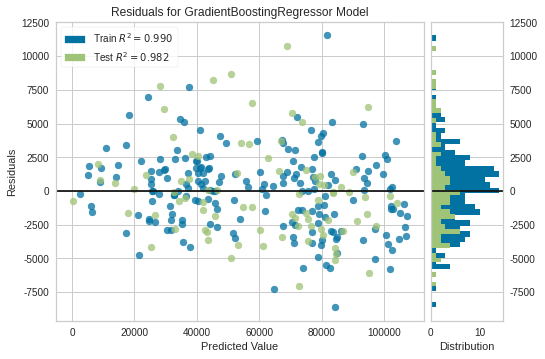

In [ ]:
plot_model(final_model_l, plot='residuals')

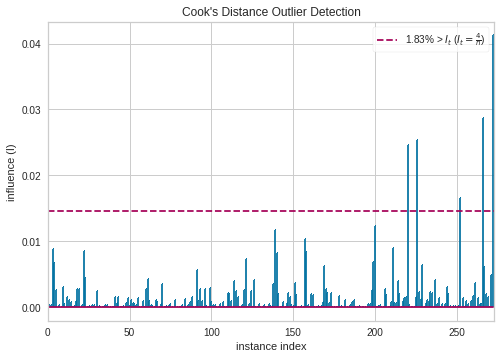

In [ ]:
plot_model(final_model_l, plot='cooks')

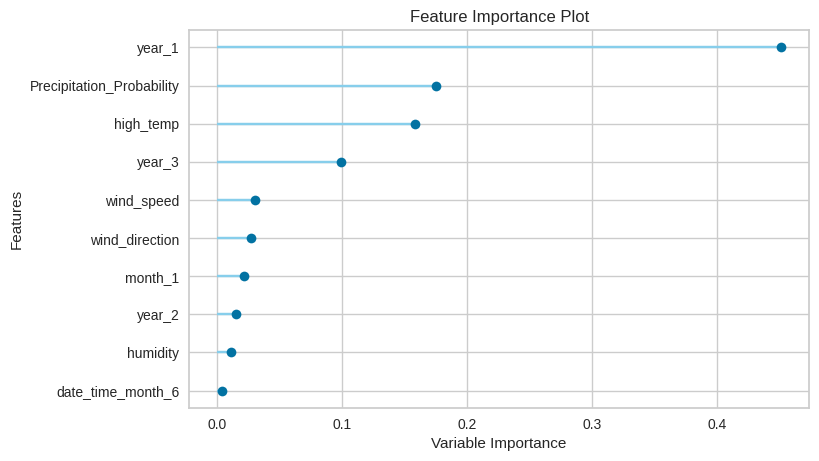

In [ ]:
plot_model(final_model_l, plot='feature')

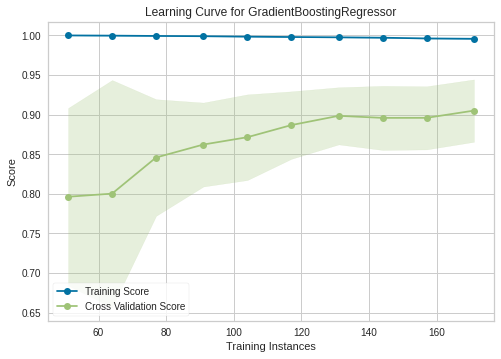

In [ ]:
plot_model(final_model_l, plot='learning')

In [ ]:
pred_esb_l.head()

In [ ]:
# submission dataFrame 완성
sample_submission['number_of_rentals'] = pred_esb_l['Label']

# 제출 파일 생성
sample_submission.to_csv(PATH + '/bicycle/dataset/ideal.csv', index= False)